# **Damaged vs undamaged trees - Random Forest classification**

## Janusz Godziek

### Project description

The aim of the project was to model tree damage using the random forest technique. The model is based on the data from tree inventories conducted in the Gorce National Park (Polish Carpathians). The dominant tree species in the study area include Norway spruce, European silver fir, and European beech. In the analyzed area the damages of trees are caused primarily by insects (mainly bark beetles) and by the wind. Trees censuses were conducted at 5-year intervals for more than 400 monitoring plots (one plot is a circle with a radius = 12 m). 

### Geocomputation part

**Data cleaning and pre-processing**

Python was applied to compute the following variables:
* minimal number of years, in which tree was growing - the number of censuses, in which tree was recorded multiplied by 5 (as censuses were conducted at 5-year intervals),
* maximal diameter at breast height (D), measured in the field,
* maximal tree volume (V), calculated based on diameter at breast height,
* maximal area of breast height cross-section (G), calculated based on diameter at breast height.

For D, V and G maximal value from 6 censuses was selected.

In [59]:
#import packages
import pandas as pd
import geopandas as gpd
import sys
import os
import numpy as np
#import gdal as gd
import fiona
import matplotlib.pyplot as plt

from osgeo import ogr
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import osmnx as ox
import numpy as np
from fnmatch import fnmatch
from os import listdir

C:\Miniconda\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Miniconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Miniconda\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Text(0, 0.5, 'percentage share [%]')

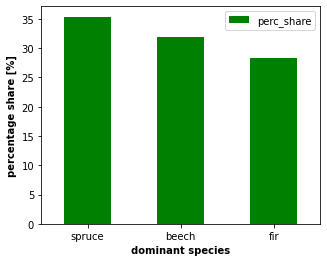

In [66]:
#read data
gpn_data = pd.read_table('forest_stand_database_GPN_20210114.txt')


trees = gpn_data[list(gpn_data.filter(regex='d'))] #select only columns starting with 'd' (diameter at breast height)
trees.columns = ['1992', '1997', '2002', '2007', '2012', '2017'] #rename columns

trees = trees.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces to NaN

dam_t = ['P', 'P/Z', 'Pk', 'Pk ', 'PW', 'Pw', 'Pz', 'Pzw', 'Ps', 'U', 'Up', 'Uzw', 'W', 'Z', 'ZW'] #list of strings (codes of damage)

for d in dam_t:
    trees = trees.replace(d, '0') #replace all code with 0 value
    
trees = trees.apply(pd.to_numeric) #convert entire dataframe to numeric
trees[trees > 0] = 1 #replace all values bigger than 0 to 1 (in entire dataframe)

#create column with categorical variable 'damage' [1 = damaged tree, 0 = not-damaged tree]
trees['dam'] = (trees == 0).sum(axis=1) 

#calculate minimal number of years, in which tree was growing (censuses in every 5 years)
trees['n_years'] = (trees == 1).sum(axis=1)*5

gpn_data1 = gpn_data.apply(pd.to_numeric, errors = 'coerce') #change all df columns to numeric (remove strings)
gpn_data1['G'] = gpn_data1[list(gpn_data1.filter(regex='G'))].max(axis=1) #max G (area of breast height cross-section)
gpn_data1['D'] = gpn_data1[list(gpn_data1.filter(regex='d'))].max(axis=1) #max diameter
gpn_data1['V'] = gpn_data1[list(gpn_data1.filter(regex='V'))].max(axis=1) #max volume
trees_data = gpn_data1[['NrPow', 'G', 'D', 'V']]  #select only columns with final values of G, D, V

#process species data
species = gpn_data[['Gatunek']] #create new dF with species
species.columns = ['Species'] #rename column
#change spruce codes (Św = pol. świerk (spruce))
species['Species'] = species['Species'].replace('Św(p)', 'Św').replace('Św(g)', 'Św').replace('Św(k)', 'Św').replace('Św(w)', 'Św').replace('Św', 'Sw')
species['Species'] = species['Species'].str.strip() #remove whitespaces from data
n_species = pd.DataFrame(species['Species'].value_counts()) #count the number of occurrence of particular species
p100 = len(species.index) #count the number of all trees

n_species['perc_share'] = n_species['Species']*100/p100 #calculate percentage share of species
n_species3 = n_species.head(3) #select first three rows (with three dominant species)
n_species3.reset_index(inplace = True) #reset index
n_species3.columns = ['sp_name', 'sp_number', 'perc_share'] #rename columns
n_species3['sp_name'] = n_species3['sp_name'].map({'Jd':'fir', 'Sw':'spruce', 'Bk':'beech'}, na_action=None)

#plot the share of dominant species (spruce, beech, fir)
ax = n_species3.plot.bar(x='sp_name', y='perc_share', rot=0, color = 'g', figsize = (5, 4))

#set axis labels
ax.set_xlabel('dominant species', size = 10, weight = 'bold')
ax.set_ylabel('percentage share [%]', size = 10, weight = 'bold')

In [67]:
trees_data = trees.iloc[:, -2:].join(trees_data) #join damages and n-years data
trees_data = trees_data.join(species)  #join species data
trees_data = trees_data.dropna() #drop all rows with NaN

#change species codes from string to integer (for modelling purposes)
trees_data['Species'] = trees_data['Species'].map({'Jd':'1', 'Sw':'2', 'Jw':'3', 'Md':'4', 'Lesz':'5', 
                                                     'Iwa':'6', 'Jrz':'7', 'Bk':'8', 'Wis':'9', 'Brzb':'10',
                                                     'Olcz':'11', 'Js':'12', 'Os':'13', 'Olsz':'14', 'Gr':'15', 
                                                     'Bst':'16'}, na_action=None)
trees_data = trees_data.replace('nan', np.nan) #replace nan with NaN
trees_data = trees_data.astype(float) #change data types to float

**Terrain analysis**

A Digital Terrain Model (DTM) and Digital Surface Model (DSM) were analyzed to check the impact of terrain properties on tree damage. DTM and DSM data were downloaded from the resources of the Polish Head Office of Geodesy and Cartography (geoportal website https://mapy.geoportal.gov.pl/imap/Imgp_2.html?gpmap=gp0&locale=en). These data were acquired in the LiDAR survey and have a spatial resolution of 1 m. The download was automated in R with the use of the rgugik package (https://www.rdocumentation.org/packages/rgugik/versions/0.3.2). Tiles were combined and clipped to the study area boundary with the use of GDAL. DTM derivatives were computed in R. Zonal statistics were performed in Python and calculated for the area of each monitoring plot (delineated as a 12 m buffer around the point location of each plot).

Download DTM and DSM data from Polish geoportal (GUGiK data) -> run in R:

In [ ]:
#load packages
library(rgugik)
library(sf)

setwd('XXXXXXX')  #set working directory

#read shp with mask
area <- read_sf('GPN_mask.shp')


#check available gugik data for study area
gugik_data <- DEM_request(area)

#subset data by certain conditions (select DTM data, resolution 1 m) 
gugik_DTM <- gugik_data[(gugik_data$product == "DTM")&(gugik_data$resolution=="1.0 m")
                        &(gugik_data$VRS=="PL-KRON86-NH")&(gugik_data$format=="ARC/INFO ASCII GRID"), ]

sheetIDs <- read.csv('GPN_mask_sheetIDs.csv') #read csv with sheet IDs
gugik_DTM <- gugik_DTM[gugik_DTM$sheetID %in% sheetIDs$godlo, ] #subset gugik_DTM with the 'godlo' column (select only sheets located within the study area)

dir.create(file.path(getwd(), 'DTM')) #create new folder for files
tile_download(gugik_DTM, file.path(getwd(), 'DTM'), unzip = T) #download tiles


#subset data by certain conditions (select DSM data, resolution 1 m) 
gugik_DSM <- gugik_data[(gugik_data$product == "DSM")&(gugik_data$resolution=="1.0 m")
                        &(gugik_data$VRS=="PL-KRON86-NH")&(gugik_data$format=="ARC/INFO ASCII GRID"), ]

gugik_DSM <- gugik_DSM[gugik_DSM$sheetID %in% sheetIDs$godlo, ] #subset gugik_DSM with the 'godlo' column (select only sheets located within the study area)


dir.create(file.path(getwd(), 'DSM')) #create new folder for files
tile_download(gugik_DSM, file.path(getwd(), 'DSM'), unzip = T) #download tiles


Mosaic DTM and DSM tiles, clip to the boundary of the study area, calculate VHM (bash & GDAL):

In [ ]:
%%bash
gdalbuildvrt TA/GPN_DTM.vrt DTM/*.asc  #built mosaic in .vrt format
gdal_translate -of GTiff -co "TILED=YES" -a_srs "epsg:2180" TA/GPN_DTM.vrt TA/GPN_DTM.tif #convert from .vrt to .tif, set crs to epsg:2180
gdalwarp -cutline GPN_mask.shp -crop_to_cutline TA/GPN_DTM.tif TA/GPN_mask_DTM.tif #crop tif to the boundary of shp

gdalbuildvrt TA/GPN_DSM.vrt DSM/*.asc  #built mosaic in .vrt format
gdal_translate -of GTiff -co "TILED=YES" -a_srs "epsg:2180" TA/GPN_DSM.vrt TA/GPN_DSM.tif #convert from .vrt to .tif, set crs to epsg:2180
gdalwarp -cutline GPN_mask.shp -crop_to_cutline TA/GPN_DSM.tif TA/GPN_mask_DSM.tif #crop tif to the boundary of shp

gdal_calc.py -A TA/GPN_mask_DSM.tif -B TA/GPN_mask_DTM.tif --outfile=TA/GPN_mask_VHM.tif --calc="A - B"  #calculate vegetation height model (VHM)

Visualize the topography of the study area

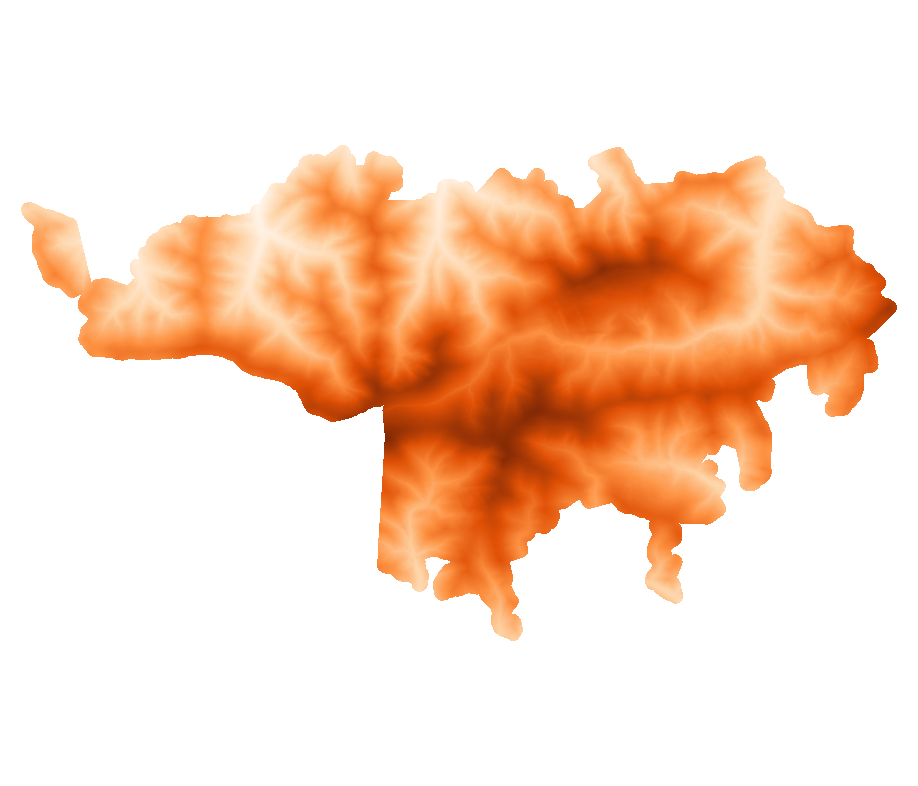

In [40]:
from IPython.display import Image
Image(filename="TA/DTM_mask.png", width = 400, height = 400)

Compute DTM derivatives -> run in R:

In [ ]:
library(Rsagacmd)
library(raster)
library(sp)

setwd('XXXXX')  #set working directory
DTM <- "TA/GPN_mask_DTM.tif"  #read DTM data


aspect_DTM <- terrain(raster(DTM), opt = "aspect", unit = "degrees") #compute aspect
slope_DTM <- terrain(raster(DTM), opt = "slope", unit = "degrees") #compute slope
crs(aspect_DTM, slope_DTM) = "EPSG:2180" #set crs
writeRaster(aspect_DTM, file.path(pth, "/", site_name, "_Aspect.tif", fsep = ""))  #export to tif
writeRaster(slope_DTM, file.path(pth, "/", site_name, "_Slope.tif", fsep = "")) #export to tif

saga = saga_gis() #read all SAGA GIS modules

BasicTA <- saga$ta_compound$basic_terrain_analysis(DTM) #execute SAGA basic terrain analysis
writeRaster(BasicTA$wetness, file.path(pth, "/", site_name, "_TWI.tif", fsep = "")) #export selected rasters to tif
writeRaster(BasicTA$hcurv, file.path(pth, "/", site_name, "_hcurv.tif", fsep = ""))
writeRaster(BasicTA$vcurv, file.path(pth, "/", site_name, "_vcurv.tif", fsep = ""))

#Wind Exposition
WindExp <- saga$ta_morphometry$wind_exposition_index(DTM)
writeRaster(WindExp, file.path(pth, "/", site_name, "_WindExp.tif", fsep = ""))

#terrain rugedness index (TRI)
TRI <- saga$ta_morphometry$terrain_ruggedness_index_tri(DTM)
writeRaster(TRI, file.path(pth, "/", site_name, "_TRI.tif", fsep = ""))


Zonal statistics - computation in Python

In [22]:
gpn_plots = gpd.read_file('powierzchnie_monitoringowe_400.shp') #read shapefile

gpn_plots_b12 = gpn_plots #create buffers
gpn_plots_b12 = gpn_plots.to_crs(2180) #set crs
gpn_plots_b12['geometry'] = gpn_plots.geometry.buffer(distance = 12) #generate buffer of 12 m around each point
gpn_plots_b12.to_file(driver = 'ESRI Shapefile', filename = "gpn_plots_b12.shp") #save to shp
gpn_plots_b12['row_num'] = np.arange(len(gpn_plots_b12)) #create column with row number
gpn_plots_b12.set_index('row_num', inplace = True) #set index
gpn_plots_b12

gpn_plots_ids = gpn_plots_b12[['id']] #new dataframe with plot IDs

In [24]:
#loop to compute zonal statistics

directory = 'TA/'
pattern = "GPN_mask_*.tif"
zs_output = [] #empty list to append results


for path, subdirs, files in os.walk(directory):
    for raster in files:
        if fnmatch(raster, pattern):
            deriv = rasterio.open(os.path.join(directory, raster))
            deriv_arr = deriv.read(1)  #convert raster to array
            deriv_affine = deriv.transform
            deriv_zs = zonal_stats(gpn_plots_b12, deriv_arr, affine = deriv_affine, stats=['min', 'max', 'mean', 'std'])
            deriv_zs = pd.DataFrame(deriv_zs) #convert to dataframe
            deriv_zs.columns = ['_min', '_max', '_mean', '_std'] #rename columns
            deriv_zs = deriv_zs.add_prefix(raster.replace('.tif', '').replace('GPN_mask_', ''))  #add prefix to each column name
            zs_output.append(deriv_zs) #append data to list
            
zs_output

zs_ta_gpn = pd.concat(zs_output, join='outer', axis=1, sort = True) #concatenate data from list to single dF
zs_ta_gpn['row_num'] = np.arange(len(zs_ta_gpn)) #create column with row number
zs_ta_gpn.set_index('row_num', inplace = True) #set index
zs_ta_gpn = gpn_plots_ids.join(zs_ta_gpn) #join with plot ID data
zs_ta_gpn.set_index('id', inplace = True) #set plot ID data as index

C:\Miniconda\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
C:\Miniconda\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Miniconda\lib\site-packages\rasterstats\main.py:235: UserWarning: Warning: converting a masked element to nan.
  feature_stats['std'] = float(masked.std())


In [ ]:
#Export data

zs_ta_gpn.to_excel('TA/zonal_statistics_TA_GPN.xlsx') #save to excel

#convert to shp, export
zs_ta_gpn2 = zs_ta_gpn.join(gpn_plots)
zs_ta_gpn2 = gpd.GeoDataFrame(zs_ta_gpn2, geometry=gpd.points_from_xy(zs_ta_gpn2.x, zs_ta_gpn2.y), 
                              crs = 'EPSG:4326') #convert to geodataframe, set crs
zs_ta_gpn2  = zs_ta_gpn2.to_crs({'init': 'EPSG:2180'}) #convert coordinates to PWG92
zs_ta_gpn2.to_file(driver = 'ESRI Shapefile', filename = "TA/zonal_statistics_TA_GPN.shp") #save to shp

### Modelling part

**Random Forest**

RandomForestClassifier from the sklearn package was applied to classify trees into 'damaged' and 'undamaged'. The performance of the model was measured by applying two metrics: Accuracy and ROC AUC.

In [68]:
#import packages
from rasterio.plot import show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [76]:
#prepair predictors
ta_gpn = pd.read_excel('TA/zonal_statistics_TA_GPN.xlsx') #read terrain analysis data
sites_gpn = pd.read_excel('sites_trees_var3.xlsx') #read sites data extracted from GPN database
variables = sites_gpn.join(ta_gpn) #join data
variables.set_index('NrPow', inplace = True) #set index

#reduce the number of variables
variables = variables.drop(['objectid', 'kod', 'geometry', 'id', 'TRI_min', 'TRI_max', 'TRI_mean', 'TRI_std',
                            'DSM_min', 'DSM_max', 'DSM_mean', 'DSM_std', 
                            'DTM_min', 'DTM_max', 'DTM_mean', 'DTM_std',
                            'PlanCurv_min', 'PlanCurv_max', 'PlanCurv_mean', 'PlanCurv_std', 
                            'ProfCurv_min', 'ProfCurv_max', 'ProfCurv_mean', 'ProfCurv_std', 
                            'WindExp_min', 'WindExp_max', 'WindExp_mean', 'WindExp_std'], axis = 1)

predictors = variables.iloc[:, 6:] #select predictors
predictors.reset_index(inplace = True)

#drop plots with not-unique number (5 plots)
predictors.drop(predictors[(predictors['NrPow'] == 11600) | (predictors['NrPow'] == 21292)].index, inplace=True)


#merge (with validation many_to_one)
trees_data_predictors = pd.merge(trees_data, predictors, how='outer', on='NrPow', validate = 'many_to_one') #merge
trees_data_predictors = trees_data_predictors.dropna() #drop rows with NaN
trees_data_predictors.insert(0, 'NrPow', trees_data_predictors.pop('NrPow')) #move the column 'NrPow' to the first position
trees_data_predictors.to_excel('trees_data_predictors_v2.xlsx') #save to excel
n = len(trees_data_predictors.index) #count number of rows of data frame
print(f'The number of trees taken into consideration in modelling is {n}.')

The number of trees taken into consideration in modelling is 17875.


In [77]:
#Apply RANDOM FOREST CLASSIFIER
#https://www.datacamp.com/tutorial/random-forests-classifier-python

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = trees_data_predictors.iloc[:, 2:].values  #predictors
Y = trees_data_predictors.iloc[:, 1].values #response variable
feat = trees_data_predictors.iloc[:, 2:].columns.values #predictors names

In [78]:
X.shape

(17875, 36)

In [79]:
Y.shape

(17875,)

In [80]:
feat

array(['n_years', 'G', 'D', 'V', 'Species', 'n_tr', 'n_sp', 'dom_sp',
       'perc_Jd', 'perc_Sw', 'perc_Bk', 'slope', 'exp', 'bedrock', 'soil',
       'hab_type', 'phyto_cmp', 'x', 'y', 'h', 'Aspect_min', 'Aspect_max',
       'Aspect_mean', 'Aspect_std', 'Slope_min', 'Slope_max',
       'Slope_mean', 'Slope_std', 'TWI_min', 'TWI_max', 'TWI_mean',
       'TWI_std', 'VHM_min', 'VHM_max', 'VHM_mean', 'VHM_std'],
      dtype=object)

In [81]:
#Create 4 dataset for training and testing the algorithm
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100, #the number of trees
                             min_samples_leaf = 5, #minimum number of samples required to be at a leaf node
                             max_features = 'auto') #the number of features to consider when looking for the best split; 
                                                    #'auto' -> max_features=sqrt(n_features)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

# Model Accuracy and ROC AUC -> how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("ROC AUC:",metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.9025509062430074
ROC AUC: 0.8402930583063716


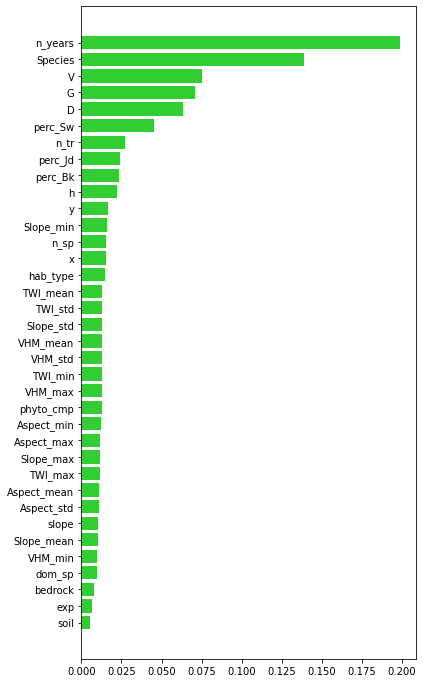

In [82]:
#check feature importance
impt = [clf.feature_importances_, np.std([tree.feature_importances_ for tree in clf.estimators_],axis=1)] 
ind = np.argsort(impt[0])

#plot the importance of predictors
plt.rcParams["figure.figsize"] = (6,12)
plt.barh(range(len(feat)),impt[0][ind],color="limegreen")
plt.yticks(range(len(feat)),feat[ind]);

**Summary**

* Applied parameters of Random Forest allowed achieving high accuracy (above 0.9). However, different RF parameters may be tested to check model performance. The choice of predictors should also be reconsidered and different combinations of predictors can be tested.
* The most important predictors are the minimal number of years, in which the tree was growing (n_years), species, and single tree parameters (V, D, G). This may prove, that older trees are much more prone to damage.
* Terrain parameters seem to not exert significant influence on tree damages.
* In the future other machine learning algorithms might be tested to model tree damage on this dataset.
